**New Addition**


*   Autoencoder for feature extraction
*   Bayesian optimization for hyperparameter tuning.



In [16]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,  classification_report , confusion_matrix , roc_auc_score , precision_score , recall_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import numpy as np

In [17]:
#load the data set
df = pd.read_csv('data.csv')

In [18]:
#Rename Columns
df_columns_new = ["Y"] + [f"X{i}" for i in range(1, len(df.columns))]
df.columns = df_columns_new
df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


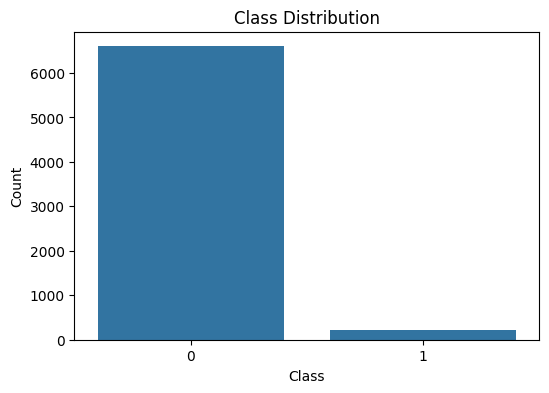

In [19]:
#Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Y', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

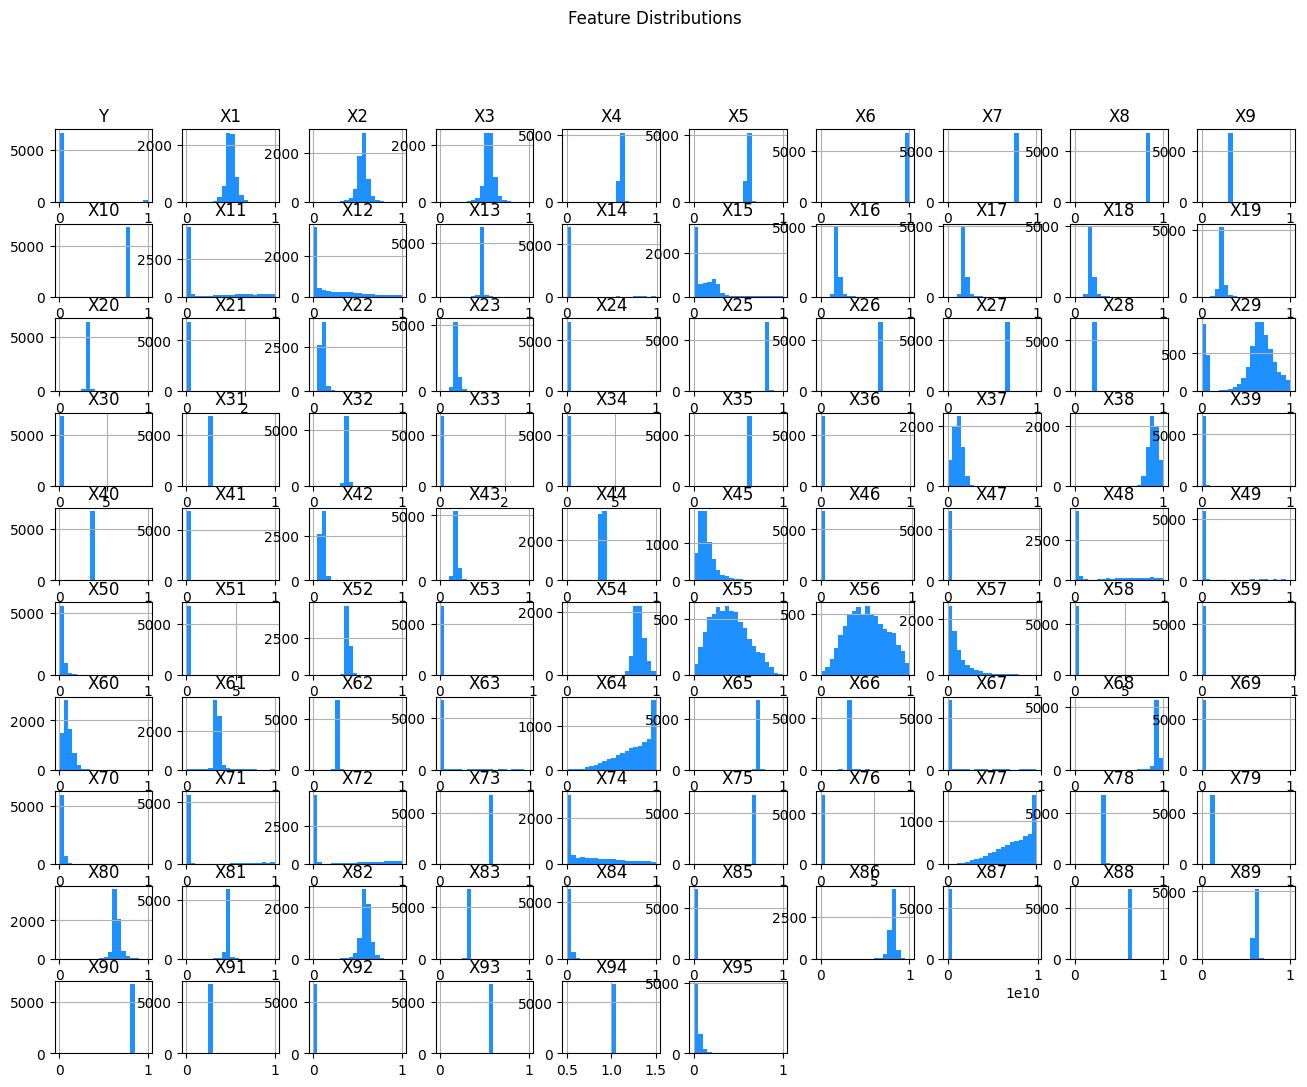

In [20]:
#Feature Distribution
df.hist(figsize=(16, 12), bins=20, color='dodgerblue')
plt.suptitle('Feature Distributions')
plt.show()

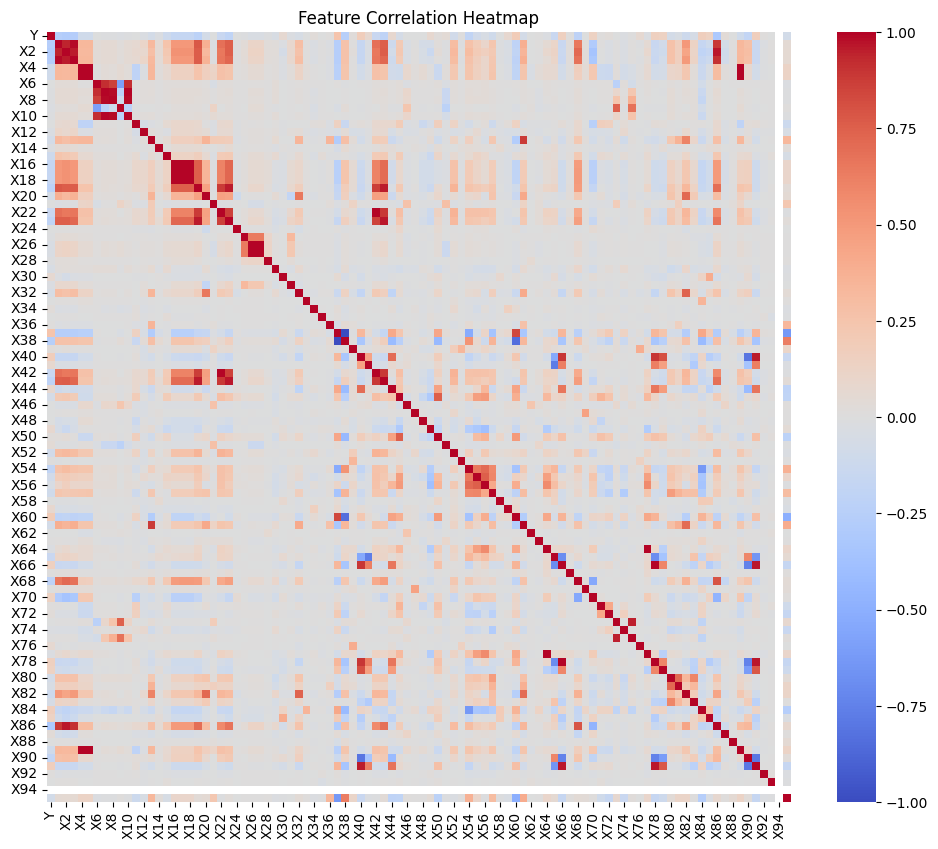

In [21]:
#Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

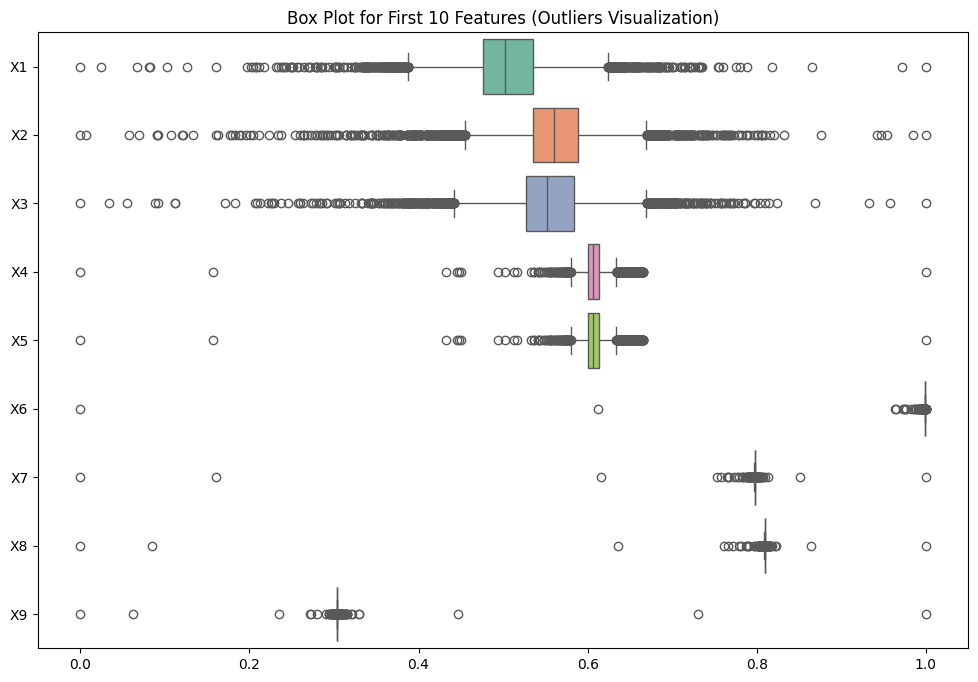

In [22]:
#Box Plot (to visualize outliers)
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.iloc[:, 1:10], orient='h', palette='Set2')  #first 10 features
plt.title('Box Plot for First 10 Features (Outliers Visualization)')
plt.show()

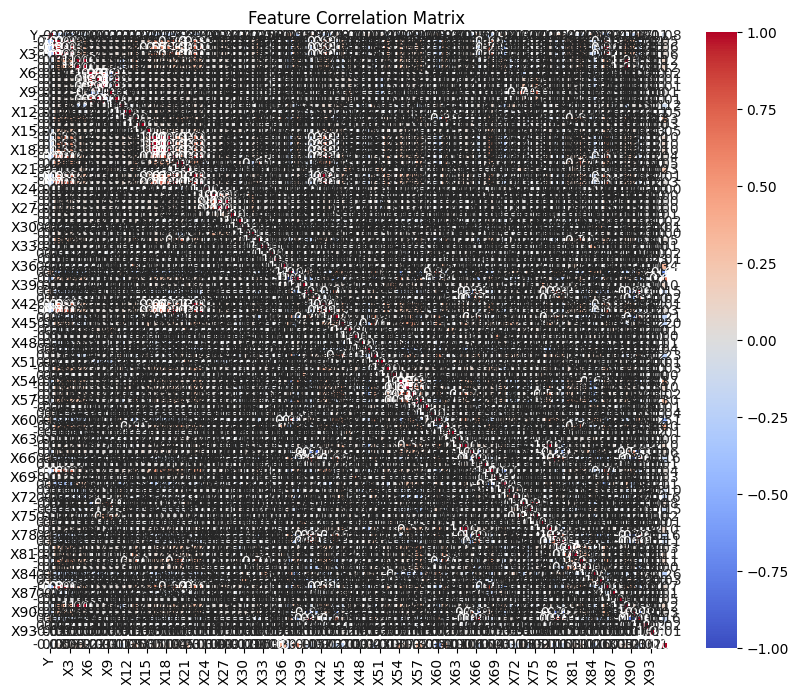

In [23]:
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

**XGBoost has built-in preprocessing mechanisms**


*   Handling Missing Data
*   Normalization and Standardization
*   Encoding
*   Feature Scaling
*   Outlier Detection and Removal

***according to this dataset, there is no need for encoding or normalization because it does not contain any categorical data, and all numerical values already fall within the range of [0, 1].***

In [24]:
#check NaN values
print("Total NaN values:",df.isnull().sum().sum())

Total NaN values: 0


In [25]:
#check duplicates
duplicates = df[df.duplicated()]
print("Number of duplicate rows:", len(duplicates))

Number of duplicate rows: 0


In [26]:
#check mean and standard deviation
mean_std = df[df.select_dtypes(include=[float, int]).columns.tolist()].agg(['mean', 'std'])
print("Mean and Standard Deviation:\n", mean_std)

Mean and Standard Deviation:
              Y        X1        X2        X3        X4        X5        X6  \
mean  0.032263  0.505180  0.558625  0.553589  0.607948  0.607929  0.998755   
std   0.176710  0.060686  0.065620  0.061595  0.016934  0.016916  0.013010   

            X7        X8        X9  ...       X86           X87       X88  \
mean  0.797190  0.809084  0.303623  ...  0.807760  1.862942e+07  0.623915   
std   0.012869  0.013601  0.011163  ...  0.040332  3.764501e+08  0.012290   

           X89       X90       X91       X92       X93  X94       X95  
mean  0.607946  0.840402  0.280365  0.027541  0.565358  1.0  0.047578  
std   0.016934  0.014523  0.014463  0.015668  0.013214  0.0  0.050014  

[2 rows x 96 columns]


In [27]:
#identify target variable and features
Y_label = [df.columns[0]]   #represent what we want to predict(bankrupt)
X_labels = df.columns[1:].tolist() #inputs used to make this prediction

X = df[X_labels].values
Y = df[Y_label].values

In [28]:
#check infinte values
inf_columns = df.columns[np.isinf(df).any(axis=0)]
print("Columns with infinite values:", inf_columns.tolist())

Columns with infinite values: []


In [29]:
#Dimensionality Reduction

#Variance Threshold used to remove features with low variance
selector = VarianceThreshold(threshold=0.1)
X_reduced = selector.fit_transform(X)

#PCA to reduce dimensionality
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_reduced)

In [31]:
#Autoencoder for feature extraction
input_dim = X_pca.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

#compile and fit the autoencoder
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_pca, X_pca, epochs=50, batch_size=256, shuffle=True)

#create the encoder model to extract features
encoder = Model(input_layer, encoded)
X_encoded = encoder.predict(X_pca)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8710684058473988096.0000
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8789106725325111296.0000
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8804618085613961216.0000
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8828137738843717632.0000
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8748952560678731776.0000
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8800930873370214400.0000
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8848843192062181376.0000
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8782600915023560704.0000
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8850692020864286720.0000
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8820371338460921856.0000
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8801861609963126784.0000
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8804013354218684416.0000
E

In [33]:
#Splitting the dataset into training and test sets
X_train , X_temp, y_train , y_temp = train_test_split(X_encoded, Y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (4091, 64)
Validation set shape: (1364, 64)
Test set shape: (1364, 64)


In [34]:
#scale_pos_weight for handling imbalance
#scale_pos_weight = float((len(y_train) / sum(y_train))/ sum(y_train))
#print("Scale pos weight:", scale_pos_weight)

#Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Resampled dataset shape:", X_resampled.shape)
print("Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())

Resampled dataset shape: (7924, 64)
Class distribution after SMOTE:
 0    3962
1    3962
Name: count, dtype: int64


In [35]:
#Define the objective function for hyperparameter optimization
def objective(params):
  model = xgb.XGBClassifier(
      n_estimators=int(params['n_estimators']),
      max_depth=int(params['max_depth']),
      min_child_weight=int(params['min_child_weight']),
      learning_rate=params['learning_rate'],
      subsample=params['subsample'],
      colsample_bytree=params['colsample_bytree'],
      eval_metric='auc',
  )
  model.fit(X_resampled, y_resampled, eval_set=[(X_val, y_val)], verbose=False)
  y_pred = model.predict(X_val)
  accuracy = accuracy_score(y_val, y_pred)
  return {'loss': -accuracy, 'status': STATUS_OK}


In [36]:
#Define the hyperparameter search space
space = {
    'n_estimators' : hp.choice('n_estimators', range(50,301)),
    'max_depth' : hp.choice('max_depth', range(3,11)),
    'min_child_weight' : hp.choice('min_child_weight', range(1,7)),
    'learning_rate' : hp.uniform('learning_rate', 0.01,0.3),
    'subsample' : hp.uniform('subsample', 0.5,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
}

In [37]:
#Run hyperparameter optimization
trials = Trials()
best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

100%|██████████| 50/50 [02:29<00:00,  2.98s/trial, best loss: -0.9648093841642229]


In [38]:
#Train the best model
best_model = xgb.XGBClassifier(
    n_estimators=int(best_hyperparams['n_estimators']),
    max_depth=int(best_hyperparams['max_depth']),
    min_child_weight=int(best_hyperparams['min_child_weight']),
    learning_rate=best_hyperparams['learning_rate'],
    subsample=best_hyperparams['subsample'],
    colsample_bytree=best_hyperparams['colsample_bytree'],
    eval_metric='auc',
)

In [39]:
#Train the best model
best_model.fit(X_resampled, y_resampled , eval_set=[(X_val, y_val)] , verbose=True)

[0]	validation_0-auc:0.67177
[1]	validation_0-auc:0.67155
[2]	validation_0-auc:0.68702
[3]	validation_0-auc:0.69700
[4]	validation_0-auc:0.68397
[5]	validation_0-auc:0.68020
[6]	validation_0-auc:0.69842
[7]	validation_0-auc:0.68228
[8]	validation_0-auc:0.68597
[9]	validation_0-auc:0.68351
[10]	validation_0-auc:0.69316
[11]	validation_0-auc:0.68818
[12]	validation_0-auc:0.68664
[13]	validation_0-auc:0.68670
[14]	validation_0-auc:0.67817
[15]	validation_0-auc:0.67203
[16]	validation_0-auc:0.66376
[17]	validation_0-auc:0.66265
[18]	validation_0-auc:0.65756
[19]	validation_0-auc:0.66314
[20]	validation_0-auc:0.65991
[21]	validation_0-auc:0.66229
[22]	validation_0-auc:0.65792
[23]	validation_0-auc:0.65881
[24]	validation_0-auc:0.65573
[25]	validation_0-auc:0.66049
[26]	validation_0-auc:0.66090
[27]	validation_0-auc:0.65989
[28]	validation_0-auc:0.66566
[29]	validation_0-auc:0.66390
[30]	validation_0-auc:0.66481
[31]	validation_0-auc:0.66609
[32]	validation_0-auc:0.66723
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6494555006899538, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.27206081135169513,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=125, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Validation Accuracy: 0.9582111436950147
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1325
           1       0.09      0.05      0.07        39

    accuracy                           0.96      1364
   macro avg       0.53      0.52      0.52      1364
weighted avg       0.95      0.96      0.95      1364

Confusion Matrix:
 [[1305   20]
 [  37    2]]


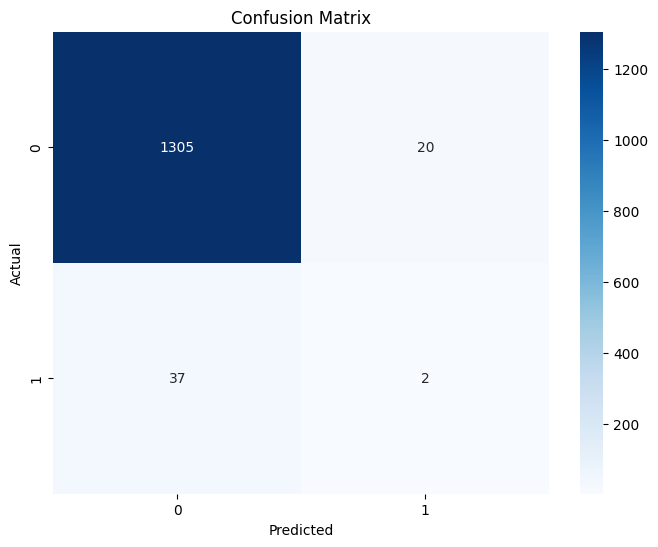

ROC AUC Score: 0.5180938558297049


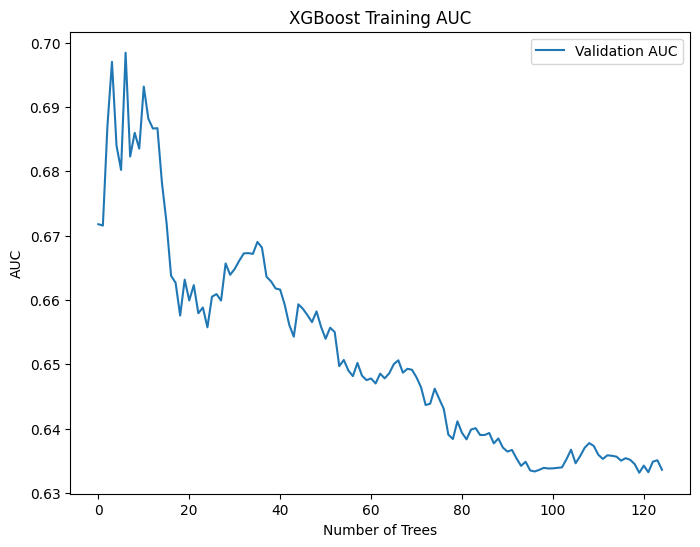

In [40]:
#Predict and evaluate on the validation set
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]
threshold = 0.4
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

#Calculate and print evaluation metrics
accuracy = accuracy_score(y_val, y_pred_adjusted)
print("Validation Accuracy:", accuracy)

report = classification_report(y_val, y_pred_adjusted)
print("Classification Report:\n", report)

conf_matrix = confusion_matrix(y_val, y_pred_adjusted)
print("Confusion Matrix:\n", conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

roc_auc = roc_auc_score(y_val, y_pred_adjusted)
print("ROC AUC Score:", roc_auc)
plt.figure(figsize=(8, 6))
plt.plot(best_model.evals_result_['validation_0']['auc'], label='Validation AUC')
plt.xlabel('Number of Trees')
plt.ylabel('AUC')
plt.title('XGBoost Training AUC')
plt.legend()
plt.show()




*   Accuracy is improved significantly with Bayesian optimization
*   Recall for Class 0 is improved. therefore model can capture more true negatives.
*   Still model struggles to predict the positive class.
*   Overall accuracy is improved.



